In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [4]:
k = 10
genes = np.zeros(k)

In [5]:
genes

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [133]:
gamma = 0.4
r_r = 1e-1
l_r = 1000
eta = 4.58e-6*5.75
l_p = 975
phi = 4.58e-6*5.75

def dN_dt(X, t=0):
    return np.array([
            gamma*X[0]*r_r/l_r - eta*X[0],
            (1-gamma)*X[0]*r_r/l_p - phi*X[1]
    ])

def cell_generation(initial_array=np.array([100,100]).reshape(1,2), timesteps=50000):
    initial_ribosomes = initial_array[-1,0]/2
    initial_proteins = initial_array[-1,1]/2
    t = np.arange(timesteps)
    
    return np.row_stack([initial_array,
                            odeint(dN_dt, [initial_ribosomes,initial_proteins], t)])

def sim_cell_dynamics(n_generations, t_per_generation):
    cell = cell_generation(timesteps=t_per_generation)
    for i in range(n_generations):
        cell = cell_generation(cell)
        
    return cell

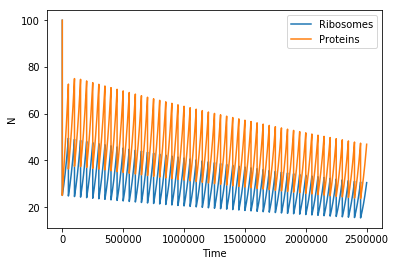

In [134]:


#t = np.arange(50000)
#solv = odeint(dN_dt, [1000,10000], t)
#solv = cellgeneration(initial_array=cellgeneration())
cell = sim_cell_dynamics(50,100)
ribo = cell[:,0]
prot = cell[:,1]
plt.plot(ribo, label='Ribosomes')
plt.plot(prot, label='Proteins')
#plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('N')
plt.legend()
plt.show()

In [128]:
cellgeneration(initial_array=cellgeneration())

array([[ 1000.        , 10000.        ],
       [  500.        ,  5000.        ],
       [  500.00683255,  4999.89909577],
       ...,
       [  980.34667468,  1660.18258718],
       [  980.36007121,  1660.1991955 ],
       [  980.37346792,  1660.21580419]])

In [36]:
ribo

array([1.        , 1.02040748, 1.04123138, 1.06248027, 1.0841628 ,
       1.10628781, 1.12886433, 1.15190159, 1.17540897, 1.19939609,
       1.22387272, 1.24884886, 1.27433469, 1.30034064, 1.3268773 ,
       1.3539555 , 1.38158629, 1.40978096, 1.438551  , 1.46790818,
       1.49786446, 1.52843207, 1.55962349, 1.59145145, 1.62392893,
       1.6570692 , 1.69088578, 1.72539247, 1.76060335, 1.7965328 ,
       1.83319548, 1.87060634, 1.90878067, 1.94773404, 1.98748236,
       2.02804185, 2.06942905, 2.11166087, 2.15475453, 2.19872761,
       2.24359805, 2.28938418, 2.33610469, 2.38377864, 2.4324255 ,
       2.48206514, 2.53271779, 2.58440413, 2.63714527, 2.69096271,
       2.74587843, 2.80191485, 2.85909482, 2.91744169, 2.97697927,
       3.03773186, 3.09972426, 3.16298177, 3.2275302 , 3.2933959 ,
       3.36060575, 3.42918719, 3.49916819, 3.57057734, 3.64344376,
       3.71779721, 3.79366801, 3.87108715, 3.95008621, 4.03069745,
       4.11295376, 4.19688871, 4.28253655, 4.36993226, 4.45911

In [94]:
2

2